In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from data import *
from amorgibbs import *
from plots import *
from torch.distributions.dirichlet import Dirichlet
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.5.0a0+3bb8c5e cuda: True


In [7]:
## range of length of tracjectories, need to be positive integers
T_min = 50
T_max = 60
K = 4
D = 2
dt = 5
Boundary = 30
noise_ratio = 10.0

## Model Parameters
num_particles_rws = 1
mcmc_steps = 50
num_particles_smc = 30
NUM_HIDDEN = 32
NUM_LATENTS = K*K
NUM_OBS = 2 * K

NUM_EPOCHS = int(1000 / mcmc_steps) 
LEARNING_RATE = 1e-3
CUDA = False
RESTORE = False
PATH_ENC = "stepwise_enc-%drws-%dmcmc-%dsmc-enc-%s" % (num_particles_rws, mcmc_steps, num_particles_smc, datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

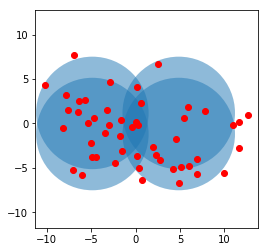

In [8]:
T = 50
noise_cov = np.array([[1, 0], [0, 1]]) * noise_ratio       
init_v = np.random.random(2) * np.random.choice([-1,1], size=2)
v_norm = ((init_v ** 2 ).sum()) ** 0.5 ## compute norm for each initial velocity
init_v = init_v / v_norm * dt ## to make the velocity lying on a circle

STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov)

plot_clusters(Y.data.numpy(), mu_ks.data.numpy(), cov_ks.data.numpy(), K)

In [9]:
from data import *
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, prior):
        A_sample = torch.zeros((K, K))
        hidden = self.enc_hidden(obs)
        variational = F.softmax(self.latent_dir(hidden), -1).sum(0).view(K, K) + prior
        for k in range(K):
            A_sample[k] = Dirichlet(variational[k]).sample()
        return variational, A_sample

In [10]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer
enc, optimizer = initialize()

In [11]:
KLs = []
EUBOs = []
ESSs = []
ELBOs = []


for epoch in range(NUM_EPOCHS):
    alpha_trans_0 = initial_trans_prior(K)
    init_v = init_velocity(dt)
    T = np.random.randint(T_min, T_max)
    STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov)
    posterior = alpha_trans_0 + pairwise(Zs_true, T).sum(0)
    kls = torch.zeros(num_particles_rws)
    Zs_list = []
    ## initialze A from uniform prior, this step does NOT involve gradient
    for l in range(num_particles_rws):
        A_samples = initial_trans(alpha_trans_0, K)
        Zs, log_weights, log_normalizer = smc_hmm(Pi, A_samples, mu_ks, cov_ks, Y, T, D, K, num_particles_smc)
        Z_ret = resampling_smc(Zs, log_weights)
        Z_ret_pairwise = torch.cat((Z_ret[:T-1].unsqueeze(0), Z_ret[1:].unsqueeze(0)), 0).transpose(0, 1).contiguous().view(T-1, 2*K)
        Zs_list.append(Z_ret_pairwise)
    for m in range(mcmc_steps):
        time_start = time.time()
        log_w = torch.zeros(num_particles_rws)
        for l in range(num_particles_rws):
            variational_curr, A_samples = enc(Z_ret_pairwise, alpha_trans_0)
            Zs, log_weights, log_normalizer = csmc_hmm(Z_ret, Pi, A_samples, mu_ks, cov_ks, Y, T, D, K, num_particles_smc)
            Z_ret = resampling_smc(Zs, log_weights)
            Z_ret_pairwise = torch.cat((Z_ret[:T-1].unsqueeze(0), Z_ret[1:].unsqueeze(0)), 0).transpose(0, 1).contiguous().view(T-1, 2*K)
            Zs_list[l] = Z_ret_pairwise
            log_w[l] = log_joint(alpha_trans_0, Z_ret, Pi, A_samples, mu_ks, cov_ks, Y, T, D, K).detach() + log_normalizer - log_joint_smc(Z_ret, Pi, A_samples, mu_ks, cov_ks, Y, T, D, K) - log_q_hmm(variational_curr, A_samples)
            kls[l] = kl_dirichlets(posterior, variational_curr, K)
        weights_rws = torch.exp(log_w - logsumexp(log_w, dim=0)).detach()
        ess = (1. / (weights_rws ** 2 ).sum()).item()
        eubo =  torch.mul(weights_rws, log_w).sum()
        elbo = log_w.mean()
        eubo.backward()
        optimizer.step()
        optimizer.zero_grad()
        EUBOs.append(eubo.item())
        ELBOs.append(elbo.item())
        ESSs.append(ess)
        KLs.append(kls.mean())
        time_end = time.time()
        print('epoch : %d, mcmc : %d, EUBO : %f, ELBO : %f, KL : %f (%ds)' % (epoch, m, eubo, elbo, kls.mean(), time_end - time_start))

epoch : 0, mcmc : 0, EUBO : -329.026947, ELBO : -336.699371, KL : 50.338860 (0s)
epoch : 0, mcmc : 1, EUBO : -333.358368, ELBO : -337.266968, KL : 50.372742 (1s)
epoch : 0, mcmc : 2, EUBO : -331.135101, ELBO : -336.147095, KL : 50.390995 (1s)
epoch : 0, mcmc : 3, EUBO : -328.535919, ELBO : -336.018005, KL : 49.819118 (1s)
epoch : 0, mcmc : 4, EUBO : -331.973724, ELBO : -337.361542, KL : 49.528198 (0s)
epoch : 0, mcmc : 5, EUBO : -327.607208, ELBO : -334.365265, KL : 49.395535 (0s)
epoch : 0, mcmc : 6, EUBO : -326.270874, ELBO : -333.551849, KL : 49.075294 (0s)
epoch : 0, mcmc : 7, EUBO : -330.786591, ELBO : -336.853119, KL : 48.597908 (0s)
epoch : 0, mcmc : 8, EUBO : -330.085968, ELBO : -334.435608, KL : 48.378563 (1s)
epoch : 0, mcmc : 9, EUBO : -325.632019, ELBO : -335.025055, KL : 48.337364 (1s)
epoch : 0, mcmc : 10, EUBO : -325.651459, ELBO : -333.107483, KL : 48.069832 (1s)
epoch : 0, mcmc : 11, EUBO : -331.127289, ELBO : -335.272095, KL : 47.853977 (1s)
epoch : 0, mcmc : 12, EUBO

KeyboardInterrupt: 

In [ ]:
save_params(KLs, EUBOs, ELBOs, ESSs, PATH_ENC)

In [ ]:
plot_results(EUBOs, ELBOs, KLs, ESSs, PATH_ENC)

In [ ]:
# plot_dirs(variational, alpha_trans_0, Zs_true, T, K, vmax=15)